In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.misc
import scipy.optimize
import matplotlib.ticker as ticker

# Parameters



In [2]:
step_size=1. # starting step_size for gradient descent
min_step_size=step_size # updates the smallest step_size during training
no_of_pts = 20 # size of dataset
np.random.seed(22) # a random seed for reproducibility
dim_layer_1=5 # the size of the first hidden layer in the target network
dim_layer_2=5 # the size of the second hidden layer in the target network
dim_in=2 # the input dimension
dim_layer_small_1=1 # the size of the first hidden layer in the target network
dim_layer_small_2=1 # the size of the second hidden layer in the target network
args = [no_of_pts,dim_in,dim_layer_1,dim_layer_2]
args_small = [no_of_pts, dim_in, dim_layer_small_1, dim_layer_small_2]


# Network design

In [3]:
# Sigmoid activation function 
# its derivative is given by f'(x)=f(x)(1-f(x))
def activation(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1./(1+np.exp(-x))

In [4]:
# Construct target network, which has two hidden layers of size 2-5-5-1, therefore we will have 10+25+5=36 weights
def network_function(inputs,u,v,w):
    layer_1 =  activation(np.dot(inputs,u)) # (batch_size, dim_layer_1)
    layer_2 = activation(np.dot(layer_1,v)) # (batch_size, dim_layer_2)
    guess = np.dot(layer_2,w) # (batch_size, dim_out)
    return guess



# Plotting functions

### Plotting the neighborhood

plotFunction() returns two images. It samples no_directions many directions in parameter space and displays the error function into all (two-sided) directions from u,v,w in one plot. The second plot contains the minimal error over all paths.

Arguments:

u,v,w= parameters 

no_directions= the number of directions to explore the loss around (u,v,w)

no_path_pts= the number of sample points along each direction (on each side)

inputs, labels = the dataset

scale=a number to adjust the scale of the image around (u,v,w)



In [5]:
def plotFunction(u,v,w,no_directions,no_path_pts,inputs,labels,scale):
    u_flat=u.flatten()
    v_flat=v.flatten()
    w_flat=w.flatten()
    variables=np.concatenate([u_flat,v_flat,w_flat])
    no_variables = variables.size
    
    directions = np.zeros(shape=(no_directions,no_variables))
    for i in range(no_directions):
        direction = 2*np.random.random(no_variables)-1.
        normalization = LA.norm(direction)
        try:
            directionUnit = direction/normalization
        except:
            directionUnit = direction
        directions[i,:]=directionUnit
    
    paths=np.zeros(shape=(no_directions, 2*no_path_pts, no_variables))
    for i in range(no_directions):
        for t in range(2*no_path_pts):
            paths[i,t,:]=variables + (-no_path_pts+t)/(no_path_pts-1)*directions[i,:]*scale

    
    error_paths = np.zeros([no_directions,2*no_path_pts])
    for i in range(no_directions):
        for t in range(2*no_path_pts):
            error_paths[i,t]=(np.sum((network_function(inputs,
                                         paths[i,t, 0:u_flat.size].reshape(u.shape),
                                         paths[i,t, u_flat.size:(u_flat.size+v_flat.size)].reshape(v.shape),
                                         paths[i,t,
                                               (u_flat.size+v_flat.size):].reshape(w.shape)
                                        )-labels)**2))       
    
    minPath = np.amin(error_paths,axis=0)
    
    x_axis=np.zeros(2*no_path_pts)
    for i in range(2*no_path_pts):
        x_axis[i]=(-no_path_pts+i)/(no_path_pts-1.)
    
   
    
    f=plt.figure(1) 
    y_formatter = ticker.ScalarFormatter(useOffset=False)

    ax =plt.subplot(211)
    ax.yaxis.set_major_formatter(y_formatter)

    for t in range(no_directions):
        plt.plot(x_axis,error_paths[t,:])
    plt.xlabel('t')
    plt.ylabel("error")
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    
    ax2=plt.subplot(212)
    ax2.yaxis.set_major_formatter(y_formatter)

    plt.plot(x_axis,minPath)
    plt.xlabel('t')
    plt.ylabel("error")

    
    plt.show
    
    f.savefig("image.pdf", bbox_inches='tight')
    
    
    return None

### Plotting into a specific direction

Shows the error function into a specific direction (both sides of the starting point)

Parameters:

u,v,w = starting parameters

direction = direction in parameter space to show the error function

no_path_pts = number of samples taking into the direction (on each side)

inputs, labels = the dataset

scale = a number to adjust the scale of the image around the starting point

In [6]:
def plotAlongDirection(u,v,w,direction,no_path_pts,inputs,labels,scale):
    u_flat=u.flatten()
    v_flat=v.flatten()
    w_flat=w.flatten()
    variables=np.concatenate([u_flat,v_flat,w_flat])
    no_variables = variables.size
       
    path=np.zeros(shape=(2*no_path_pts, no_variables))
    for t in range(2*no_path_pts):
        path[t,:]=variables + (-no_path_pts+t)/(no_path_pts-1)*direction*scale

    error_path = np.zeros(2*no_path_pts)
    for t in range(2*no_path_pts):
        error_path[t]=(np.sum((network_function(inputs,
                                                     path[t, 0:u_flat.size].reshape(u.shape),
                                                     path[t, u_flat.size:(u_flat.size+v_flat.size)].reshape(v.shape),
                                                     path[t,(u_flat.size+v_flat.size):].reshape(w.shape)
                                                    ) -labels)**2))       
    
    x_axis=np.zeros(2*no_path_pts)
    for i in range(2*no_path_pts):
        x_axis[i]=(-no_path_pts+i)/float(no_path_pts-1.)
    
    f=plt.figure(1)
    y_formatter = ticker.ScalarFormatter(useOffset=False)
    
    ax =plt.subplot(111)
    ax.yaxis.set_major_formatter(y_formatter)

    
    plt.plot(x_axis,error_path)
    plt.xlabel('t')
    plt.ylabel("error")            
    plt.show
    
    f.savefig("image.pdf", bbox_inches='tight')
    
    return None

# Define target function and dataset

In [7]:
# Initialze weights for layers randomly
u = 10*np.random.random((dim_in,dim_layer_1))-5 # (dim_in, dim_layer_1)
v = 10*np.random.random((dim_layer_1,dim_layer_2))-5  # (dim_layer_1, dim_layer_2)
w = 10*np.random.random((dim_layer_2,1))-5  # (dim_layer_2, dim_out)

In [8]:
# Choose input
inputs =np.random.random((no_of_pts,dim_in))

In [9]:
# Create labels
labels = network_function(inputs,u,v,w)

# Create smaller network by initializing new weights

In [10]:
# Construct network, which has two hidden layers of size indim=2-1-1-1
U = 10*np.random.random((dim_in,dim_layer_small_1))-5 # (dim_in, dim_layer_small_1)
V = 10*np.random.random((dim_layer_small_1,dim_layer_small_2))-5  # (dim__layer_small_1, dim_layer_small_2)
W = 10*np.random.random((dim_layer_small_2,1))-5  # (dim_layer_small_2, dim_out)

# Train the smaller network to match the dataset defined by the larger one

In [11]:
def flat_weights(U,V,W):
    return np.concatenate([U.flatten(),V.flatten(),W.flatten()])

weights_flat = flat_weights(U,V,W)

In [12]:
def unflat_weights(weights_flat, args):
    U = weights_flat[:args[1]*args[2]].reshape(args[1],args[2])
    V = weights_flat[args[1]*args[2]: (args[1]+args[3])*args[2]].reshape(args[2],args[3])
    W = weights_flat[(args[1]+args[3])*args[2]:].reshape(args[3],1)
    return U,V,W

In [13]:
def flat_dataset_and_args(inputs, labels, args):
    return np.concatenate([inputs.flatten(), labels.flatten(),args])

dataset_and_args_flat = flat_dataset_and_args(inputs, labels, args_small)

In [14]:
def unflat_dataset_and_args(dataset_and_args_flat):
    args = dataset_and_args_flat[-4:].astype(int)
    inputs = dataset_and_args_flat[:args[0]*args[1]].reshape(args[0],args[1])
    labels = dataset_and_args_flat[args[0]*args[1]:-4].reshape(args[0],1)
    return inputs, labels, args

In [15]:
def optimizer_function(weights_flat,dataset_and_args_flat):
    inputs,labels,args = unflat_dataset_and_args(dataset_and_args_flat)
    U,V,W = unflat_weights(weights_flat,args)
    guess = network_function(inputs,U,V,W)
    error = np.sum((guess-labels)**2)
    return error

In [16]:
result = scipy.optimize.minimize( optimizer_function , weights_flat, dataset_and_args_flat, method='BFGS', options={'gtol': 1e-100})

In [17]:
U,V,W = unflat_weights(result['x'],args_small)


In [18]:
optimizer_function(result['x'], dataset_and_args_flat)

4.8174941053601215

# Checking partial derivatives of the loss function after training

### The partial derivatives of the loss function with respect to parameters U,V and W (sum over directions for each layer)

In [19]:
def error_U(uu):
    guess = network_function(inputs,uu,V,W)
    return np.sum((guess - labels)**2)
def error_V(vv):
    guess = network_function(inputs,U,vv,W)
    return np.sum((guess - labels)**2)
def error_W(ww):
    guess = network_function(inputs,U,V,ww)
    return np.sum((guess - labels)**2)

In [20]:
scipy.misc.derivative(error_U,U,dx=1e-10),scipy.misc.derivative(error_V,V,dx=1e-10),scipy.misc.derivative(error_W,W,dx=1e-10)

(0.0, 8.881784197001252e-06, 4.440892098500626e-06)

### We also compute the partial derivatives of the function itself (mean over directions for each layer). Note that these are nonzero in contrast to the partial derivatives of the loss function.

In [21]:
def n_U(uu):
    return np.mean(network_function(inputs, uu, V, W))
def n_V(vv):
    return np.mean(network_function(inputs, U, vv, W))
def n_W(ww):
    return np.mean(network_function(inputs, U, V, ww))


In [22]:
scipy.misc.derivative(n_U,U,dx=1e-10),scipy.misc.derivative(n_V,V,dx=1e-10),scipy.misc.derivative(n_W,W,dx=1e-10)

(0.036098901645686965, 0.049013015868126786, 0.7284484127012547)

# Check the necessary condition of positive definiteness of matrix B to add a neuron to the first hidden layer using its neuron

In [23]:
guess=network_function(inputs,U,V,W)
layer_1 = activation(np.dot(inputs,U)) # (batch_size, dim_layer_1)
layer_2 = activation(np.dot(layer_1,V)) #(batch_size, dim_layer_2)
dh_by_dn = W[0,0]*activation(layer_2, deriv=True).reshape(20,1,1)
sigma_double_prime = (layer_1[:,0] - 3*layer_1[:,0]**2+2*layer_1[:,0]**3)
summands=(((guess-labels)*(np.dot(dh_by_dn,V[0])))*sigma_double_prime.reshape(no_of_pts,1)).reshape(no_of_pts,1,1) *(inputs.reshape(no_of_pts,1,dim_in)*inputs.reshape(no_of_pts,dim_in,1))
B = np.sum(summands,0)
B

array([[0.01175238, 0.00856659],
       [0.00856659, 0.00692156]])

In [24]:
eigenValues = np.linalg.eig(B)[0]
eigenValues

array([0.01823757, 0.00043636])

In [25]:
definiteness = "B is "
if all(i > 0 for i in eigenValues):
    definiteness+="positive definite"
elif all(i < 0 for i in eigenValues):
    definiteness+="negative definite"
else:
    definiteness+="neither positive nor negative definite."
definiteness

'B is positive definite'

# Verify theory that when using the first hidden layer, the matrix D is zero, which is also a necessary condition for finding a local minimum.

In [26]:
np.sum((guess-labels).reshape(no_of_pts,1,1)*dh_by_dn*((layer_1[:,0]*(1-layer_1[:,0])).reshape(no_of_pts,1,1))*(inputs.reshape(no_of_pts,dim_in,1)),0)


array([[1.78733908e-08],
       [9.55997694e-09]])

# Check the necessary condition of positive definiteness of matrix B to add a neuron to the last hidden layer using its neuron

In [27]:
guess=network_function(inputs,U,V,W)
layer_1 = activation(np.dot(inputs,U)) # (batch_size, dim_layer_1)
layer_2 = activation(np.dot(layer_1,V)) #(batch_size, dim_layer_2)
dh_by_dn = np.ones(no_of_pts).reshape([no_of_pts,1,1]) 
sigma_double_prime = (layer_2[:,0] - 3*layer_2[:,0]**2+2*layer_2[:,0]**3)
summands=(((guess-labels)*(np.dot(dh_by_dn,W[0])))*sigma_double_prime.reshape(no_of_pts,1)).reshape(no_of_pts,1,1) *(layer_1.reshape(no_of_pts,1,dim_layer_small_1)*layer_1.reshape(no_of_pts,dim_layer_small_1,1))
B = np.sum(summands,0)
B

array([[0.07565885]])

In [28]:
eigenValues = np.linalg.eig(B)[0]
eigenValues

array([0.07565885])

In [29]:
definiteness = "B is "
if all(i > 0 for i in eigenValues):
    definiteness+="positive definite"
elif all(i < 0 for i in eigenValues):
    definiteness+="negative definite"
else:
    definiteness+="neither positive nor negative definite."
definiteness

'B is positive definite'

# Verify theory that when using the last hidden layer, the matrix D is zero, which is also a necessary condition for finding a local minimum.

In [30]:
np.sum((guess-labels).reshape(no_of_pts,1,1)*dh_by_dn*((layer_2[:,0]*(1-layer_2[:,0])).reshape(no_of_pts,1,1))*(layer_1.reshape(no_of_pts,dim_layer_small_1,1)),0)


array([[2.39339063e-08]])

# We add one neuron to the first hidden layer

In [31]:
U_new = np.concatenate([U[:,0].reshape(dim_in,1),U],axis=1)

In [32]:
V_new=np.concatenate([V[0,:].reshape(1,dim_layer_small_2),V], axis = 0)*np.array([[2/3],[1/3]])

In [33]:
W_new=W

# We add one neuron to the second hidden layer

In [34]:
V_new = np.concatenate([V_new[:,0].reshape(dim_layer_small_1+1,1),V_new],axis=1)

In [35]:
W_new=np.concatenate([W_new[0,:].reshape(1,dim_layer_small_2),W_new], axis = 0)*np.array([[2/3],[1/3]])

# Plot the neighbourhood of the point to verify it is a local minimum

#### First we check the point in original network (before adding one neuron)

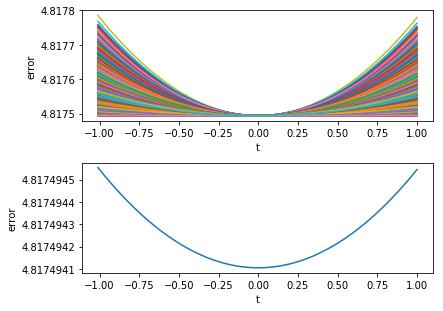

In [36]:
plotFunction(U,V,W,1000,100,inputs,labels,0.005)

### Now for the larger network

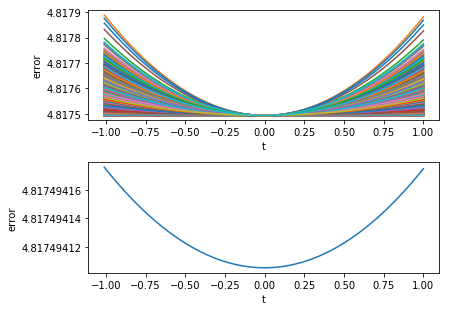

In [37]:
plotFunction(U_new,V_new,W_new,1000,100,inputs,labels,0.005)

# Now we change to a saddle point in the larger network (of the same loss value) and check it's neighbourhood. 

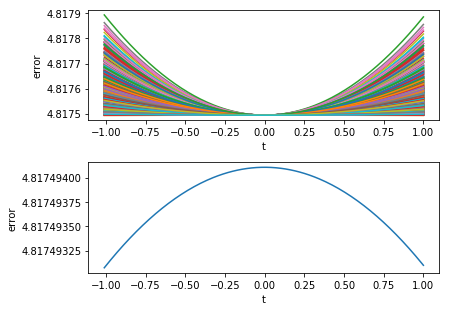

In [38]:
U_saddle = U_new
V_saddle = V_new
W_saddle=W_new*np.array([[3/2*(-1)],[3*2]])
plotFunction(U_saddle,V_saddle,W_saddle,1000,100,inputs,labels,0.005)

#### We see that the saddle point is close to a local minimum, i.e., most of the eigenvalues of the loss Hessian are positive, but there are directions to further decrease the loss

## We verify the degenerate direction in which the loss does not change and which allows to move from a local minimum to a saddle point

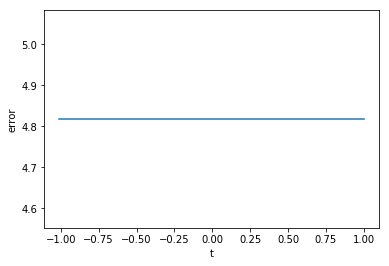

In [39]:
direction_U_degenerate=np.zeros(U_new.flatten().shape)
direction_V_degenerate = np.zeros(V_new.flatten().shape)
direction_W_degenerate=np.concatenate([W[0,:],-W[0,:],np.zeros( ( W_new[2:,:].flatten()).shape) ])

direction_degenerate = np.concatenate([direction_U_degenerate, direction_V_degenerate, direction_W_degenerate])


plotAlongDirection(U_new,V_new,W_new,direction_degenerate,100,inputs,labels,0.1)


# We verify that we can indeed reach a saddle point by such a path of nondegeneracy

For the saddle point from above, we used $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta,0)=(2,1,0)$ for V

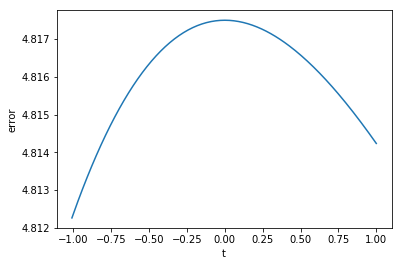

In [40]:
direction_U_saddle=np.zeros(U_saddle.flatten().shape)
direction_V_saddle = np.concatenate([2*V_saddle[:,0:1],V_saddle[:,0:1],np.zeros( (V_saddle[:,2:]).shape ) ],axis=1).flatten()
direction_W_saddle= np.zeros(W_saddle.flatten().shape)

direction_saddle=np.concatenate([direction_U_saddle, direction_V_saddle, direction_W_saddle] )

plotAlongDirection(U_saddle,V_saddle,W_saddle,direction_saddle,100,inputs,labels,0.05)


Note that we do indeed reach points with strictly smaller loss along this direction.

## We add several (five) neurons in the above way to both hidden layers, go through the same steps and get the same results. The neural network we get is larger than the one we constructed the dataset with and theoretically can attain zero loss.

#### We begin by adding neurons to the first hidden layer

In [41]:
U_large = np.concatenate([U[:,0].reshape(dim_in,1),U[:,0].reshape(dim_in,1),U[:,0].reshape(dim_in,1),U[:,0].reshape(dim_in,1),U[:,0].reshape(dim_in,1),U],axis=1)

In [42]:
V_large=np.concatenate([V[0,:].reshape(1,1),V[0,:].reshape(1,1),V[0,:].reshape(1,1),V[0,:].reshape(1,1),V[0,:].reshape(1,1),V], axis = 0)*np.array([[1./9.],[2./9.],[2./27.],[4./27.],[4./27.],[8./27.]])

In [43]:
W_large=W

#### We continue by adding neurons to the second hidden layer

In [44]:
V_large_2 = np.concatenate([V_large[:,0].reshape(6,1),V_large[:,0].reshape(6,1),V_large[:,0].reshape(6,1),V_large[:,0].reshape(6,1),V_large[:,0].reshape(6,1),V_large],axis=1)

In [45]:
W_large_2=np.concatenate([W_large[0,:].reshape(1,1),W_large[0,:].reshape(1,1),W_large[0,:].reshape(1,1),W_large[0,:].reshape(1,1),W_large[0,:].reshape(1,1),W_large], axis = 0)*np.array([[1./9.],[2./9.],[2./27.],[4./27.],[4./27.],[8./27.]])

In [46]:
U_large_2=U_large

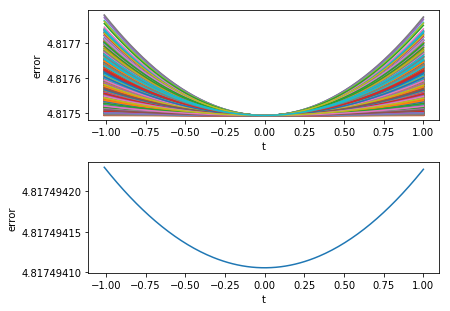

In [47]:
plotFunction(U,V,W,1000,100,inputs,labels,0.005)

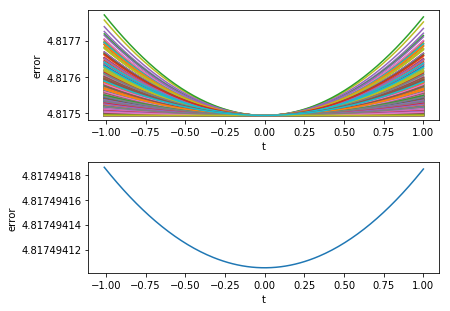

In [48]:
plotFunction(U_large_2,V_large_2,W_large_2,1000,100,inputs,labels,0.005)

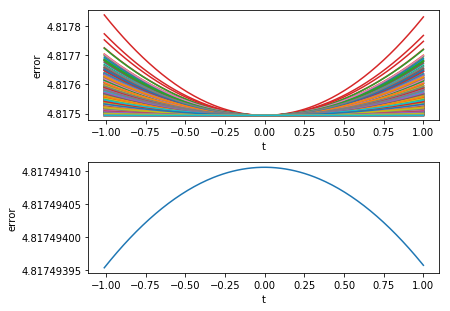

In [49]:
U_saddle_large = U_large_2
V_saddle_large = V_large_2
W_saddle_large=W_large_2*np.array([[-3.],[3.],[1.],[1.],[1.],[1.]])
plotFunction(U_saddle_large,V_saddle_large,W_saddle_large,1000,100,inputs,labels,0.005)

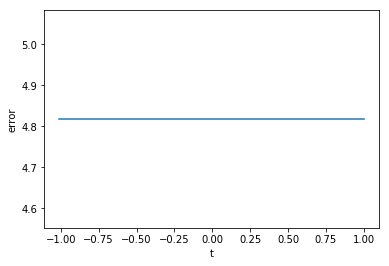

In [50]:
direction_U_large_degenerate=np.zeros(U_large_2.flatten().shape)
direction_V_large_degenerate = np.zeros(V_large_2.flatten().shape)
direction_W_large_degenerate = np.concatenate([W_large_2[0,:], -W_large_2[0,:], np.zeros( ( W_large_2[2:,:].flatten()).shape)])

direction_large_degenerate = np.concatenate([direction_U_large_degenerate, direction_V_large_degenerate, direction_W_large_degenerate])


plotAlongDirection(U_large_2,V_large_2,W_large_2,direction_large_degenerate,100,inputs,labels,0.1)


A connected saddle is located, for example, where  $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta)=(2,1)$

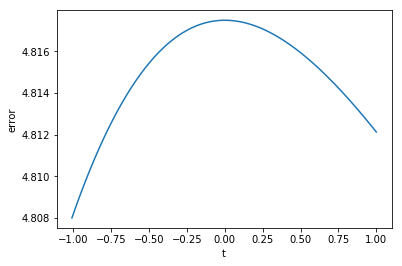

In [51]:
direction_U_large_saddle=np.zeros(U_saddle_large.flatten().shape)
direction_V_large_saddle = np.concatenate([2*V_saddle_large[:,0:1],np.zeros( (V_saddle_large[:,1:3]).shape ),V_saddle_large[:,0:1],np.zeros( (V_saddle_large[:,4:]).shape ) ],axis=1).flatten()
direction_W_large_saddle= np.zeros(W_saddle_large.flatten().shape)

direction_large_saddle=np.concatenate([direction_U_large_saddle, direction_V_large_saddle, direction_W_large_saddle] )

plotAlongDirection(U_saddle_large,V_saddle_large,W_saddle_large,direction_large_saddle,100,inputs,labels,0.1)


# We increase the network by adding twenty neurons to make it overparameterized

### We first add to the first hidden layer to make this layer extremely wide 

In [52]:
U_overpara = np.concatenate([U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U[:,0].reshape(dim_in,1),
                             U],axis=1)

In [53]:
V_overpara=np.concatenate([V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V[0,:].reshape(1,1),
                           V], axis = 0)*np.array([[2.**19/(3.**20)],
                                                   [2.**18/(3.**19)],
                                                   [2.**17/(3.**18)],
                                                   [2.**16/(3.**17)],
                                                   [2.**15/(3.**16)],
                                                   [2.**14/(3.**15)],
                                                   [2.**13/(3.**14)],
                                                   [2.**12/(3.**13)],
                                                   [2.**11/(3.**12)],
                                                   [2.**10/(3.**11)],
                                                   [2.**9/(3.**10)],
                                                   [2.**8/(3.**9)],
                                                   [2.**7/(3.**8)],
                                                   [2.**6/(3.**7)],
                                                   [2.**5/(3.**6)],
                                                   [2.**4/(3.**5)],
                                                   [8./(3.**4)],
                                                   [4./27.],
                                                   [2./9.],
                                                   [1./3.],
                                                   [2.**20/(3.**20)]])

In [54]:
W_overpara=W

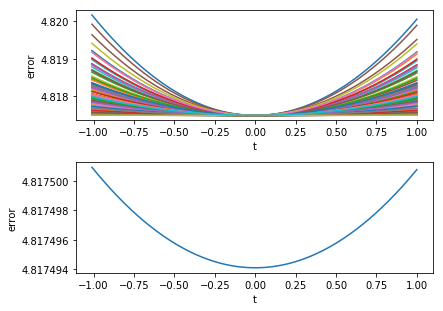

In [55]:
plotFunction(U_overpara,V_overpara,W_overpara,100,100,inputs,labels,0.05)

### We now add the same number of neurons to the second hidden layer to also make this layer extremely wide

In [56]:
V_overpara_2 = np.concatenate([V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara[:,0].reshape(21,1),
                             V_overpara],axis=1)
V_overpara_2.shape


(21, 21)

In [57]:
W_overpara_2=np.concatenate([W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara[0,:].reshape(1,1),
                           W_overpara], axis = 0)*np.array([[2.**19/(3.**20)],
                                                   [2.**18/(3.**19)],
                                                   [2.**17/(3.**18)],
                                                   [2.**16/(3.**17)],
                                                   [2.**15/(3.**16)],
                                                   [2.**14/(3.**15)],
                                                   [2.**13/(3.**14)],
                                                   [2.**12/(3.**13)],
                                                   [2.**11/(3.**12)],
                                                   [2.**10/(3.**11)],
                                                   [2.**9/(3.**10)],
                                                   [2.**8/(3.**9)],
                                                   [2.**7/(3.**8)],
                                                   [2.**6/(3.**7)],
                                                   [2.**5/(3.**6)],
                                                   [2.**4/(3.**5)],
                                                   [8./(3.**4)],
                                                   [4./27.],
                                                   [2./9.],
                                                   [1./3.],
                                                   [2.**20/(3.**20)]])
W_overpara_2.shape

(21, 1)

In [58]:
U_overpara_2=U_overpara
U_overpara_2.shape

(2, 21)

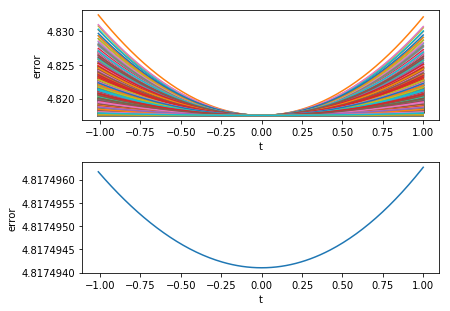

In [59]:
plotFunction(U_overpara_2,V_overpara_2,W_overpara_2,5000,100,inputs,labels,0.05)

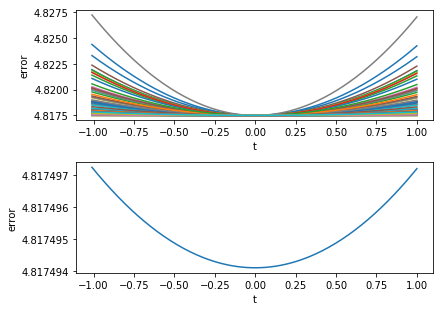

In [60]:
U_saddle_overpara = U_overpara_2
V_saddle_overpara = V_overpara_2
W_saddle_overpara=W_overpara_2*np.array([[-3.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [1.],
                                       [3.]])
plotFunction(U_saddle_overpara,V_saddle_overpara,W_saddle_overpara,100,100,inputs,labels,0.05)

### In such high dimension, it is unlikely to find a direction of descent by random sampling of directions. But we know a direction by construction, which we will now use.

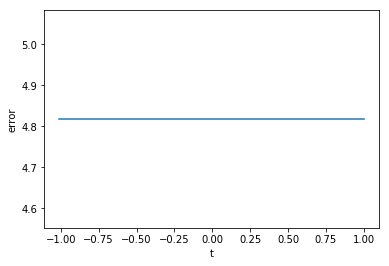

In [61]:
direction_U_overpara_degenerate=np.zeros(U_overpara_2.flatten().shape)
direction_V_overpara_degenerate = np.zeros(V_overpara_2.flatten().shape)
direction_W_overpara_degenerate=np.concatenate([np.zeros( ( W_overpara_2[1:20,:].flatten()).shape), W_overpara_2[0,:], -W_overpara_2[0,:] ])

direction_overpara_degenerate = np.concatenate([direction_U_overpara_degenerate, direction_V_overpara_degenerate, direction_W_overpara_degenerate])


plotAlongDirection(U_overpara_2,V_overpara_2,W_overpara_2,direction_overpara_degenerate,100,inputs,labels,0.1)


At the saddle, we have $\lambda=-1=\frac{\beta}{\alpha+\beta}$, hence $\alpha+\beta=-\beta$ or $\alpha=-2\beta$. 

Therefore, the direction of descent is given by $(\alpha,-\beta)=(2,1)$

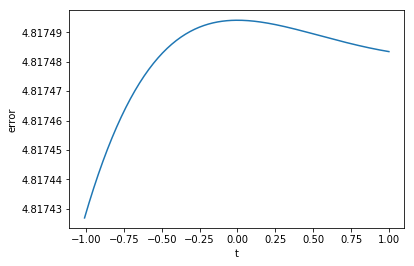

In [62]:
direction_U_overpara_saddle=np.zeros(U_saddle_overpara.flatten().shape)
direction_V_overpara_saddle = np.concatenate([2*V_saddle_overpara[:,0:1],np.zeros( (V_saddle_overpara[:,1:20]).shape ),V_saddle_overpara[:,0:1]],axis=1).flatten()
direction_W_overpara_saddle= np.zeros(W_saddle_overpara.flatten().shape)

direction_overpara_saddle=np.concatenate([direction_U_overpara_saddle, direction_V_overpara_saddle, direction_W_overpara_saddle] )

plotAlongDirection(U_saddle_overpara,V_saddle_overpara,W_saddle_overpara,direction_overpara_saddle,100,inputs,labels,0.2)


## We test another direction that has more influence on the loss by using the direction from adding the first neuron instead of the last

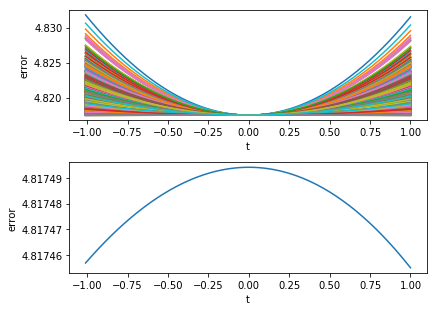

In [63]:
U_saddle_overpara = U_overpara_2
V_saddle_overpara = V_overpara_2
W_saddle_overpara=W_overpara_2*np.array([[3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [3.],
                                       [-3.],
                                       [3.]])
plotFunction(U_saddle_overpara,V_saddle_overpara,W_saddle_overpara,5000,100,inputs,labels,0.05)

### The point is still almost a local minimum, but this time we did find random directions that slightly reduce the loss 

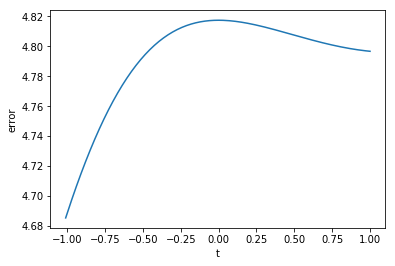

In [64]:
direction_U_overpara_saddle=np.zeros(U_saddle_overpara.flatten().shape)
direction_V_overpara_saddle = np.concatenate([V_saddle_overpara[:,0:19],2*V_saddle_overpara[:,0:1],V_saddle_overpara[:,0:1]],axis=1).flatten()
direction_W_overpara_saddle= np.zeros(W_saddle_overpara.flatten().shape)

direction_overpara_saddle=np.concatenate([direction_U_overpara_saddle, direction_V_overpara_saddle, direction_W_overpara_saddle] )

plotAlongDirection(U_saddle_overpara,V_saddle_overpara,W_saddle_overpara,direction_overpara_saddle,100,inputs,labels,0.2)
